- Image classification (MNIST digits recognition)
- Approach: Bidirectional-LSTM on original pictures and rotated pictures to process pictures from 4 directions
- Result: with 5 epochs, training accuracy = 0.9646, validation accuracy = 0.9627, training loss = 0.1219, validation loss = 0.1239

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import GRU, Bidirectional, GlobalMaxPooling1D
from keras.layers import Input, LSTM, Lambda, Concatenate, Dense
import keras.backend as K

In [4]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    # CuDNNLSTM: Fast LSTM implementation backed by CuDNN
    # Can only be run on GPU, with the TensorFlow backend.
    from keras.layers import CuDNNLSTM as LSTM 
    from keras.layers import CuDNNGRU as GRU

In [7]:
# load in MNIST dataset
def get_mnist(limit = None):
    if not os.path.exists('../large_files/MNIST/train.csv'):
        print("Please download MNIST dataset from https://www.kaggle.com/c/digit-recognizer")
    
    print("Loading in and transforming data...")
    df = pd.read_csv('../large_files/MNIST/train.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:].reshape(-1, 28, 28) / 255.0
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [8]:
X, Y = get_mnist(limit = None)
print(X.shape)
print(Y.shape)

Loading in and transforming data...
(42000, 28, 28)
(42000,)


In [9]:
# Configuration
D = 28
M = 15 # hidden layer units

In [11]:
# Bidirectional-LSTM
input_ = Input(shape = (D, D))

# bottom-top 2 directions
rnn1 = Bidirectional(LSTM(M, return_sequences = True))
x1 = rnn1(input_) # size: N x D x 2M
x1 = GlobalMaxPooling1D()(x1) # size: N x 2M

# left-right 2 directions
rnn2 = Bidirectional(LSTM(M, return_sequences = True))
# layer for rotating pictures
rotate_layer = Lambda(lambda t: K.permute_dimensions(t, pattern = (0,2,1)))
x2 = rotate_layer(input_)
x2 = rnn2(x2) # size: N x D x 2M
x2 = GlobalMaxPooling1D()(x2) # size: N x 2M

# concatenate
concatenator = Concatenate(axis = 1)
x = concatenator([x1, x2]) # size: N x 4M

# dense layer
output = Dense(10, activation = 'softmax')(x)

model = Model(inputs = input_, outputs = output)
model.compile(
    # use 'sparse_...' loss to avoiding one-hot encoding labels
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [12]:
# train the model
r = model.fit(X, Y, batch_size = 32, epochs = 5, validation_split = 0.3)

Train on 29399 samples, validate on 12601 samples
Epoch 1/5
29399/29399 [==============================] - 52s 2ms/step - loss: 0.7770 - acc: 0.8033 - val_loss: 0.3076 - val_acc: 0.9200
Epoch 2/5
29399/29399 [==============================] - 50s 2ms/step - loss: 0.2472 - acc: 0.9313 - val_loss: 0.2084 - val_acc: 0.9417
Epoch 3/5
29399/29399 [==============================] - 50s 2ms/step - loss: 0.1760 - acc: 0.9496 - val_loss: 0.1576 - val_acc: 0.9548
Epoch 4/5
29399/29399 [==============================] - 50s 2ms/step - loss: 0.1411 - acc: 0.9594 - val_loss: 0.1430 - val_acc: 0.9558
Epoch 5/5
29399/29399 [==============================] - 49s 2ms/step - loss: 0.1219 - acc: 0.9646 - val_loss: 0.1239 - val_acc: 0.9627


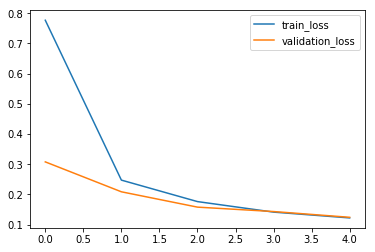

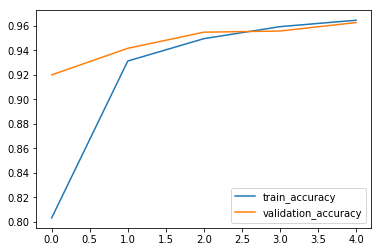

In [14]:
# visulization loss and accuracy
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label = 'train_accuracy')
plt.plot(r.history['val_acc'], label = 'validation_accuracy')
plt.legend()
plt.show()